### IMPORTANT!!!
If you choose to use Google Colab to run this notebook keep in mind that the time you have available to use a GPU in Colab is limited (no exact limit but 6-10 hours in a continuous session might lead to a CPU only restriction). The more you use Colab GPU the more often you will get restricted. Do NOT spend more than 4-5 hours training for this notebook as there are other assignments that you will need GPU for.

# Assignment 1: Deep Learning

This assignment is divided into two excercises. First, you are asked to create a fully connected neural network for classification. Next, 
you are asked to create a convolutional neural network. You will then be able to see the gain in performance for yourself.

For these assignments you are going to use the [PyTorch](https://pytorch.org/docs/stable/index.html) framework. The dataset that is used throughout the assignment is [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html). It contains 60 000 images evenly split in 10 classes.
There are 50 000 train images and 10 000 test images.

### Importing necessary libraries

In [18]:
import os, sys, random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, sampler

import torchvision.datasets as datasets
import torchvision.transforms as T

from tqdm import tqdm

import numpy as np

# Check if notebook is not imported
training = __name__ == '__main__'
if training:
    import pickle
    from collections import OrderedDict
    import matplotlib.pyplot as plt

### Preparation

You have the option to use GPU by setting the flag bellow to **True**. If your computer does not have CUDA enabled the notebook will fallback to CPU mode.

Use the global variables `dtype` and `device` throughout the assignment.

#### Important!!

Make sure to run the following blocks sequentially

In [19]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print("Using device: ", device)

Using device:  cuda


In [20]:
# defining some helper functions
# you do not need to use any of them in your own code
# DO NOT MODIFY

def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)
    

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    
def check_accuracy(model, loader, device, dtype=torch.float32):
    """A helper function used to calculate loss and accuracy on an entire dataset.
        DO NOT MODIFY!

        Args:
            model: torch model.
            loader: torch dataloader.

        Returns:
            accuracy, loss (List[]): accuracy and loss for the whole dataset.
    """
    total_samples = 0
    loss = 0
    correct_samples = 0
    samples = len(loader.dataset)
    model.eval()
    with torch.no_grad():
        for (x, y) in loader:
            x = x.to(device=device, dtype=dtype) 
            y = y.to(device=device, dtype=dtype)
            scores = torch.argmax(model(x), dim=1).to(dtype=dtype)
            loss += F.cross_entropy(scores, y).cpu()
            correct_samples += (scores == y).sum().item()
            total_samples += y.shape[0]
            
    return np.array([float(correct_samples) / total_samples, loss / samples])



In [21]:
# Set some global variables and configure environment
RANDOM_SEED = 420
BATCH_SIZE = 250  # Set the batch size you want to use
TRAIN_VAL_SPLIT = 0.9
NUMBER_OF_CLASSES = 10

set_all_seeds(RANDOM_SEED)
set_deterministic()

Let us begin by downloading (the first time is slower as the data downloaded then it is loaded form disk) the dataset and creating the loaders for training validation and test.

In [22]:
# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation

train_transforms = T.Compose([T.Resize((70, 70)),
                                T.RandomCrop((64, 64)),
                                T.ToTensor(),
                                T.Normalize((0.49139968, 0.48215827, 0.44653124), 
                                            (0.24703233, 0.24348505, 0.26158768))])

test_transforms = T.Compose([T.Resize((70, 70)),
                                T.CenterCrop((64, 64)),
                                T.ToTensor(),
                                T.Normalize((0.49139968, 0.48215827, 0.44653124), 
                                            (0.24703233, 0.24348505, 0.26158768))])

def get_loaders(train_transforms=train_transforms, test_transforms=test_transforms):
    """ Get dataloaders. Usefull later when creating custom transforms

    Args:
        train_transforms (_type_, optional): transforms for training data. Defaults to train_transforms.
        test_transforms (_type_, optional): transforms for test/validation data. Defaults to test_transforms.

    Returns:
        _type_: _description_
    """
    train_dataset = datasets.CIFAR10(root='./CIFAR10',
                                        train=True,
                                        transform=train_transforms,
                                        download=True)

    validation_dataset = datasets.CIFAR10(root='./CIFAR10',
                                        train=True,
                                        transform=test_transforms)

    test_dataset = datasets.CIFAR10(root='./CIFAR10',
                                        train=False,
                                        transform=test_transforms)

    dataset_size = len(train_dataset)
    loader_train = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              sampler=sampler.SubsetRandomSampler(range(int(dataset_size*TRAIN_VAL_SPLIT)), 
                                                                  generator=torch.Generator().manual_seed(RANDOM_SEED)))

    loader_validation = DataLoader(validation_dataset, 
                                   batch_size=BATCH_SIZE, 
                                   sampler=sampler.SubsetRandomSampler(range(int(dataset_size*TRAIN_VAL_SPLIT),
                                                                             dataset_size)))

    loader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    return loader_train, loader_validation, loader_test

if training:
    loader_train, loader_validation, loader_test = get_loaders()
else:
    loader_train = loader_validation = loader_test = None

Files already downloaded and verified


Let us look at a sample from the dataset.

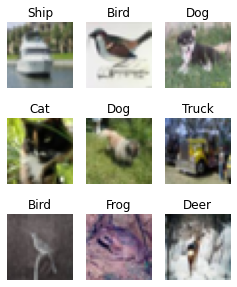

In [23]:
if training:
    plot_dataset = datasets.CIFAR10(root='./CIFAR10',
                                        train=True,
                                        transform=T.Compose([T.ToTensor()]),
                                        download=False)
    labels_map = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck",
    }
    figure = plt.figure(figsize=(4, 5))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(plot_dataset), size=(1,)).item()
        img, label = plot_dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.numpy().transpose(1, 2, 0).squeeze())
    plt.show()

Let us define a simple fully connected network. You are going to use that model to verify your training loop later. You can see that this network has a little over `6.8 milion` trainable parameters.

In [24]:
model = nn.Sequential(
    # Flatten the 2D image to 1D
    nn.Flatten(),
    nn.Linear(64*64*3, 512, device=device, dtype=dtype),
    nn.ReLU(),
    nn.Linear(512, 512, device=device, dtype=dtype),
    nn.ReLU(),
    nn.Linear(512, 512, device=device, dtype=dtype),
    nn.ReLU(),
    nn.Linear(in_features=512 , out_features=NUMBER_OF_CLASSES, device=device, dtype=dtype)
)

trainable_parameters = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable parameters: {trainable_parameters}")

Trainable parameters: 6822410


Let us define an optimizer and loss function. You are going to use those later to train your model. 

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss = nn.CrossEntropyLoss()

## Exercise 1 A: Create training loop

You need to create the [training](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) loop yourself. Start by generating your model's predictions. Zero the gradients, do a backpropagation step, followed, by an optimizer step.

In [26]:
def train_model(model, optimizer=optimizer, loss=loss, epochs=1, device=device,
                loader_train=loader_train, loader_validation=loader_validation):
    """Train a model with a given optimizer and loss for a set amount of epochs.

    Args:
        model : PyTorch model
        optimizer : An optimizer object. Defaults to optimizer.
        loss : Loss function. Defaults to loss.
        epochs (int, optional): Number of epochs to train for. Defaults to 1.
    """
    
    model = model.to(device=device) # move model to device
    # create dictionary to keep a log of data
    log_dict = {'train_loss_per_batch': [],
                'train_accuracy_per_epoch': [],
                'train_loss_per_epoch': [],
                'valid_accuracy_per_epoch': [],
                'valid_loss_per_epoch': [],
                'accuracy_deviation': [],
                }
    
    for epoch in range(epochs): # iterate for number of epochs
        print("Epoch: ", epoch + 1)
        with tqdm(total=len(loader_train)) as pbar: # loading bar, ignore
            for index, (x, y) in enumerate(loader_train): # iterate over each batch
                model.train() # put model in training mode
                x = x.to(device=device, dtype=dtype) # move images to device
                y = y.to(device=device, dtype=torch.long) # move labels to device
                
# BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                # model output
                
                #outputs = model(x)
                scores = model(x)
        
                # calculate loss
                #loss = loss_fn(outputs, labels)
                output_loss = loss(scores, y)
                
                # zero gradients
                optimizer.zero_grad()
                
                # backward propagation
                output_loss.backward()
                
                # optimizer step
                optimizer.step()
                
# END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                
                # log
                log_dict['train_loss_per_batch'].append(output_loss.item())
                
                postfix_dict = { # output of loading bar
                    'loss' : output_loss.item(),
                }
                if not index: # collect data at iteration zero, check if testing
                    if training:
                        train_data = check_accuracy(model, loader_train, device)
                        log_dict['train_accuracy_per_epoch'].append(train_data[0])
                        log_dict['train_loss_per_epoch'].append(train_data[1])
                        val_data = check_accuracy(model, loader_validation, device)
                        log_dict['valid_accuracy_per_epoch'].append(val_data[0])
                        log_dict['valid_loss_per_epoch'].append(val_data[1])
                        log_dict['accuracy_deviation'].append(
                            train_data[0] - val_data[0])
                        print(f"Validation accuracy: {val_data[0]*100:.2f}",
                            f" Deviation: {(train_data[0] - val_data[0])*100:.2f}")
                    
                pbar.set_postfix(**postfix_dict) # set loading bar output
                    
                pbar.update(1)
                sys.stdout.flush()
    
    if training: # check if function is being tested
        train_data = check_accuracy(model, loader_train, device)
        log_dict['train_accuracy_per_epoch'].append(train_data[0])
        log_dict['train_loss_per_epoch'].append(train_data[1])
        val_data = check_accuracy(model, loader_validation, device)
        log_dict['valid_accuracy_per_epoch'].append(val_data[0])
        log_dict['valid_loss_per_epoch'].append(val_data[1])
        log_dict['accuracy_deviation'].append(train_data[0] - val_data[0])
        print(f"Validation accuracy: {val_data[0]*100:.2f}", 
            f" Deviation: {(train_data[0] - val_data[0])*100:.2f}")
    
    return log_dict

### Train the model and evaluate performance
Let us train the model for 10 epochs and evaluate performance on the test dataset. Plot accuracy and loss per epoch.

In [27]:
epochs = 10
if training:
    log_dict = train_model(model, optimizer, loss, epochs)
    print("Test set accuracy: ", check_accuracy(model, loader_test, device)[0])

Epoch:  1


  1%|          | 1/180 [00:30<1:30:14, 30.25s/it, loss=2.3]

Validation accuracy: 17.24  Deviation: -0.22


100%|██████████| 180/180 [00:55<00:00,  3.22it/s, loss=1.59]


Epoch:  2


  1%|          | 1/180 [00:26<1:17:41, 26.04s/it, loss=1.53]

Validation accuracy: 45.18  Deviation: -0.14


100%|██████████| 180/180 [00:51<00:00,  3.50it/s, loss=1.64]


Epoch:  3


  1%|          | 1/180 [00:26<1:18:28, 26.31s/it, loss=1.52]

Validation accuracy: 48.96  Deviation: 0.58


100%|██████████| 180/180 [00:51<00:00,  3.48it/s, loss=1.42]


Epoch:  4


  1%|          | 1/180 [00:25<1:15:36, 25.35s/it, loss=1.43]

Validation accuracy: 50.82  Deviation: 0.84


100%|██████████| 180/180 [00:50<00:00,  3.57it/s, loss=1.31]


Epoch:  5


  1%|          | 1/180 [00:25<1:15:33, 25.33s/it, loss=1.36]

Validation accuracy: 52.64  Deviation: 1.61


100%|██████████| 180/180 [00:50<00:00,  3.56it/s, loss=1.44]


Epoch:  6


  1%|          | 1/180 [00:25<1:15:55, 25.45s/it, loss=1.26]

Validation accuracy: 52.90  Deviation: 3.21


100%|██████████| 180/180 [00:50<00:00,  3.54it/s, loss=1.29]


Epoch:  7


  1%|          | 1/180 [00:25<1:17:02, 25.83s/it, loss=1.22]

Validation accuracy: 53.90  Deviation: 3.45


100%|██████████| 180/180 [00:51<00:00,  3.49it/s, loss=1.25]


Epoch:  8


  1%|          | 1/180 [00:25<1:15:42, 25.38s/it, loss=1.1]

Validation accuracy: 54.78  Deviation: 4.36


100%|██████████| 180/180 [00:50<00:00,  3.55it/s, loss=1.15]


Epoch:  9


  1%|          | 1/180 [00:25<1:17:01, 25.82s/it, loss=1.19]

Validation accuracy: 55.20  Deviation: 5.46


100%|██████████| 180/180 [00:51<00:00,  3.51it/s, loss=1.22]


Epoch:  10


  1%|          | 1/180 [00:25<1:15:40, 25.37s/it, loss=1.05]

Validation accuracy: 55.26  Deviation: 6.57


100%|██████████| 180/180 [00:50<00:00,  3.57it/s, loss=1.26]


Validation accuracy: 56.32  Deviation: 6.60
Test set accuracy:  0.5551


Leet us look at a plot of the accuracy and loss.

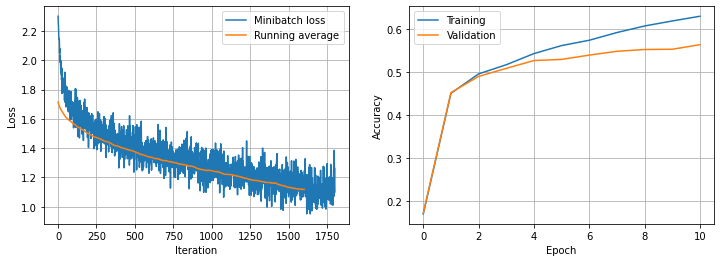

In [28]:
def plot_accuracy_loss(log_dict, epochs=epochs, training=training):
    if training:
        figure = plt.figure(1, figsize=(12, 4))
        figure.add_subplot(1, 2, 1)
        batch_loss = log_dict['train_loss_per_batch']
        plt.plot(batch_loss, label='Minibatch loss')
        plt.plot(np.convolve(batch_loss, np.ones(200,)/200, mode='valid'), label='Running average')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        plt.grid()
        plt.legend()
        
        figure.add_subplot(1, 2, 2)
        plt.plot(np.arange(0, epochs+1), log_dict['train_accuracy_per_epoch'], label='Training')
        plt.plot(np.arange(0, epochs+1), log_dict['valid_accuracy_per_epoch'], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()
        plt.show()
        
if training:
    plot_accuracy_loss(log_dict)

## Exercise 1 B: Fully connected neural network

In this exercise you are asked to create a fully connected neural network. Create a network consisting of 7 linear layers. The network should follow a diamond structure, make the first layer with 512 nodes and double this for each next node untill the middle layer (layer 4), then half for the layers following that. The last layer should then have 512 nodes. Add [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) activation after each layer. Make sure to [flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the input layer.

<center>

| Layer | Type | Output size | Activation |
| ------|------|:-----------:|:----------:| 
| Input |Image |    64x64    | ReLU       |
| 1     |Linear|     512     | ReLU       |
| 2     |Linear|     1024    | ReLU       |
| 3     |Linear|     2048    | ReLU       |
| 4     |Linear|     4096    | ReLU       |
| 5     |Linear|     2048    | ReLU       |
| 6     |Linear|     1024    | ReLU       |
| 7     |Linear|     512     | ReLU       |
| 8     |Linear|     10      | ReLU       |

</center>

In [29]:
def model_fcnn():
    return nn.Sequential(
                # Flatten the 2D image to 1D
# BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                nn.Flatten(),
                nn.Linear(64*64*3, 512, device=device, dtype=dtype),
                nn.ReLU(),
                nn.Linear(512, 1024, device=device, dtype=dtype),
                nn.ReLU(),
                nn.Linear(1024, 2048, device=device, dtype=dtype),
                nn.ReLU(),
                nn.Linear(2048, 4096, device=device, dtype=dtype),
                nn.ReLU(),
                nn.Linear(4096, 2048, device=device, dtype=dtype),
                nn.ReLU(),
                nn.Linear(2048, 1024, device=device, dtype=dtype),
                nn.ReLU(),
                nn.Linear(1024, 512, device=device, dtype=dtype),
                nn.ReLU(),
                nn.Linear(512, 10, device=device, dtype=dtype)
# END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
            )
model = model_fcnn()

print("Model: ", model)

Model:  Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=12288, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=1024, bias=True)
  (4): ReLU()
  (5): Linear(in_features=1024, out_features=2048, bias=True)
  (6): ReLU()
  (7): Linear(in_features=2048, out_features=4096, bias=True)
  (8): ReLU()
  (9): Linear(in_features=4096, out_features=2048, bias=True)
  (10): ReLU()
  (11): Linear(in_features=2048, out_features=1024, bias=True)
  (12): ReLU()
  (13): Linear(in_features=1024, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=10, bias=True)
)


Train the network and plot results. Do not forget to define an optimizer and loss function. Use Adam with a learning rate of 0.0001 and an appropritate loss. Train the model for 10 epochs.

Epoch:  1


  1%|          | 1/180 [00:27<1:21:31, 27.33s/it, loss=2.3]

Validation accuracy: 11.70  Deviation: -1.06


100%|██████████| 180/180 [00:56<00:00,  3.17it/s, loss=1.64]


Epoch:  2


  1%|          | 1/180 [00:26<1:19:30, 26.65s/it, loss=1.7]

Validation accuracy: 41.62  Deviation: 0.15


100%|██████████| 180/180 [00:56<00:00,  3.20it/s, loss=1.54]


Epoch:  3


  1%|          | 1/180 [00:27<1:20:49, 27.09s/it, loss=1.52]

Validation accuracy: 47.52  Deviation: -0.19


100%|██████████| 180/180 [00:57<00:00,  3.12it/s, loss=1.43]


Epoch:  4


  1%|          | 1/180 [00:26<1:19:56, 26.80s/it, loss=1.38]

Validation accuracy: 49.96  Deviation: 1.27


100%|██████████| 180/180 [00:56<00:00,  3.19it/s, loss=1.45]


Epoch:  5


  1%|          | 1/180 [00:26<1:18:32, 26.33s/it, loss=1.31]

Validation accuracy: 52.48  Deviation: 1.36


100%|██████████| 180/180 [00:55<00:00,  3.26it/s, loss=1.34]


Epoch:  6


  1%|          | 1/180 [00:26<1:19:34, 26.68s/it, loss=1.2]

Validation accuracy: 52.84  Deviation: 4.74


100%|██████████| 180/180 [00:56<00:00,  3.21it/s, loss=1.21]


Epoch:  7


  1%|          | 1/180 [00:26<1:18:45, 26.40s/it, loss=1.25]

Validation accuracy: 53.86  Deviation: 5.13


100%|██████████| 180/180 [00:55<00:00,  3.25it/s, loss=1.14]


Epoch:  8


  1%|          | 1/180 [00:26<1:19:42, 26.72s/it, loss=1.11]

Validation accuracy: 54.64  Deviation: 6.87


100%|██████████| 180/180 [00:55<00:00,  3.22it/s, loss=1.09]


Epoch:  9


  1%|          | 1/180 [00:26<1:17:46, 26.07s/it, loss=0.99]

Validation accuracy: 54.88  Deviation: 8.65


100%|██████████| 180/180 [00:54<00:00,  3.27it/s, loss=1.08]


Epoch:  10


  1%|          | 1/180 [00:26<1:19:15, 26.57s/it, loss=0.843]

Validation accuracy: 56.68  Deviation: 10.10


100%|██████████| 180/180 [00:55<00:00,  3.23it/s, loss=0.917]


Validation accuracy: 56.80  Deviation: 13.98
Test set accuracy:  0.5629


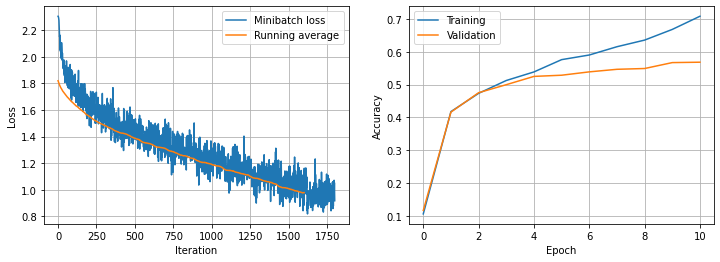

In [30]:
epochs = 10
# BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fcnn = nn.CrossEntropyLoss()
# END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
if training:
    log_dict = train_model(model, optimizer, loss_fcnn, epochs)
    print("Test set accuracy: ", check_accuracy(model, loader_test, device)[0])
    plot_accuracy_loss(log_dict, epochs)

Let us have a look at the number of trainable parameters in the network you defined.

In [31]:
trainable_parameters = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable parameters: {trainable_parameters}")

Trainable parameters: 28327946


While the performance of the example network and the FCNN you defined is simmilar, the latter has around 4 times the number of trainable parameters.

## Exercise 2 A: Convolutional Neural Networks

In this exercise you are asked to implement a convolutional neural network. You can observe the accuracy increase compared to a FCNN. Later you are going to extend the network in order to achieve a higher accuracy.

Implement a scaled down version of AlexNet. To that end you will use knowledge from the previous exercise but you would also need to add [convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [droput](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and [max pooling layers](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).

The architecture is summarized in the table bellow:

<center>

| Layer | Type | Feature map | Output size | Kernel size | Stride | Padding | Activation |
| ------|------|:-----------:|:-----------:|:-----------:|:------:|:-------:|:----------:| 
| Input |Image |      3      |    64x64    | None        | None   | None    | None       |
| 1     |Conv  |      24     |    32x32    | 7x7         | 2      | 3       | ReLU       |
| 2     |Max pool|    24     |    16x16    | 3x3         | 2      | 1       | None       |
| 3     |Conv  |      64     |    16x16    | 5x5         | 1      | 2       | ReLU       |
| 4     |Max pool|    64     |     8x8     | 3x3         | 2      | 1       | None       |
| 5     |Conv  |      96     |     8x8     | 3x3         | 1      | 1       | ReLU       |
| 6     | Max pool|   96     |     4x4     | 3x3         | 2      | 1       | None       |
| 7     |Linear|     None    |    1024     | None        | None   | None    | ReLU       |
| 8     |Dropout|    None    |     0.5     | None        | None   | None    | None       |
| 9     |Linear|     None    |    1024     | None        | None   | None    | ReLU       |
| 10    |Dropout|    None    |     0.5     | None        | None   | None    | None       |
| 11    |Linear|     None    |     10      | None        | None   | None    | None       |

</center>


In [32]:
def model_alexnet():
    return nn.Sequential(
# BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        nn.Conv2d(3, 24, kernel_size=7, stride=2, padding=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        
        nn.Conv2d(24, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        
        nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        
        nn.Flatten(),
        nn.Linear(96*4*4, 1024, device=device, dtype=dtype),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        
        nn.Linear(1024, 1024, device=device, dtype=dtype),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        
        nn.Linear(1024, 10, device=device, dtype=dtype)
# END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 
)

model = model_alexnet()

trainable_parameters = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable parameters: {trainable_parameters}")

Trainable parameters: 2731146


Train for 20 epochs. Define the loss function and optimizer. Use Adam with a learning rate of `0.001` and an appropriate loss. Plot the results after that. You should achive test set accuracy of around `77%`.

Epoch:  1


  1%|          | 1/180 [00:31<1:34:18, 31.61s/it, loss=2.3]

Validation accuracy: 13.68  Deviation: -0.30


100%|██████████| 180/180 [01:00<00:00,  2.98it/s, loss=1.77]


Epoch:  2


  1%|          | 1/180 [00:27<1:22:42, 27.73s/it, loss=1.77]

Validation accuracy: 37.00  Deviation: 0.01


100%|██████████| 180/180 [00:56<00:00,  3.21it/s, loss=1.54]


Epoch:  3


  1%|          | 1/180 [00:26<1:18:14, 26.23s/it, loss=1.61]

Validation accuracy: 45.66  Deviation: -0.19


100%|██████████| 180/180 [00:54<00:00,  3.29it/s, loss=1.38]


Epoch:  4


  1%|          | 1/180 [00:27<1:22:11, 27.55s/it, loss=1.37]

Validation accuracy: 50.20  Deviation: -0.57


100%|██████████| 180/180 [00:55<00:00,  3.23it/s, loss=1.29]


Epoch:  5


  1%|          | 1/180 [00:26<1:18:35, 26.34s/it, loss=1.22]

Validation accuracy: 53.82  Deviation: -0.60


100%|██████████| 180/180 [00:55<00:00,  3.26it/s, loss=1.23]


Epoch:  6


  1%|          | 1/180 [00:26<1:19:41, 26.71s/it, loss=1.22]

Validation accuracy: 56.22  Deviation: -0.02


100%|██████████| 180/180 [00:55<00:00,  3.25it/s, loss=1.24]


Epoch:  7


  1%|          | 1/180 [00:26<1:18:13, 26.22s/it, loss=1.13]

Validation accuracy: 59.46  Deviation: -0.92


100%|██████████| 180/180 [00:55<00:00,  3.27it/s, loss=1.11]


Epoch:  8


  1%|          | 1/180 [00:26<1:19:29, 26.64s/it, loss=1.13]

Validation accuracy: 59.48  Deviation: 0.06


100%|██████████| 180/180 [00:55<00:00,  3.27it/s, loss=1.09]


Epoch:  9


  1%|          | 1/180 [00:26<1:19:17, 26.58s/it, loss=1.13]

Validation accuracy: 62.12  Deviation: -0.57


100%|██████████| 180/180 [00:55<00:00,  3.26it/s, loss=0.991]


Epoch:  10


  1%|          | 1/180 [00:26<1:18:51, 26.43s/it, loss=1.12]

Validation accuracy: 64.10  Deviation: -0.25


100%|██████████| 180/180 [00:55<00:00,  3.24it/s, loss=1.06]


Epoch:  11


  1%|          | 1/180 [00:26<1:20:26, 26.97s/it, loss=1.13]

Validation accuracy: 65.16  Deviation: -0.14


100%|██████████| 180/180 [00:55<00:00,  3.26it/s, loss=0.959]


Epoch:  12


  1%|          | 1/180 [00:26<1:18:25, 26.29s/it, loss=1.02]

Validation accuracy: 66.04  Deviation: -0.48


100%|██████████| 180/180 [00:55<00:00,  3.26it/s, loss=0.935]


Epoch:  13


  1%|          | 1/180 [00:26<1:19:47, 26.74s/it, loss=1.02]

Validation accuracy: 67.42  Deviation: 0.19


100%|██████████| 180/180 [00:54<00:00,  3.28it/s, loss=0.981]


Epoch:  14


  1%|          | 1/180 [00:26<1:17:53, 26.11s/it, loss=0.959]

Validation accuracy: 69.00  Deviation: -0.39


100%|██████████| 180/180 [00:55<00:00,  3.24it/s, loss=0.965]


Epoch:  15


  1%|          | 1/180 [00:26<1:17:46, 26.07s/it, loss=0.904]

Validation accuracy: 68.30  Deviation: 0.66


100%|██████████| 180/180 [00:54<00:00,  3.31it/s, loss=0.878]


Epoch:  16


  1%|          | 1/180 [00:26<1:18:41, 26.38s/it, loss=0.904]

Validation accuracy: 70.00  Deviation: 0.86


100%|██████████| 180/180 [00:56<00:00,  3.20it/s, loss=0.964]


Epoch:  17


  1%|          | 1/180 [00:26<1:18:08, 26.19s/it, loss=0.92]

Validation accuracy: 70.66  Deviation: 1.16


100%|██████████| 180/180 [00:54<00:00,  3.30it/s, loss=0.878]


Epoch:  18


  1%|          | 1/180 [00:26<1:20:07, 26.86s/it, loss=0.793]

Validation accuracy: 71.44  Deviation: 0.52


100%|██████████| 180/180 [00:55<00:00,  3.25it/s, loss=1.01]


Epoch:  19


  1%|          | 1/180 [00:26<1:19:35, 26.68s/it, loss=0.837]

Validation accuracy: 72.90  Deviation: 0.86


100%|██████████| 180/180 [00:54<00:00,  3.28it/s, loss=0.797]


Epoch:  20


  1%|          | 1/180 [00:26<1:20:31, 26.99s/it, loss=0.747]

Validation accuracy: 72.46  Deviation: 1.14


100%|██████████| 180/180 [00:55<00:00,  3.27it/s, loss=0.727]


Validation accuracy: 73.22  Deviation: 1.31
Test set accuracy:  0.7123


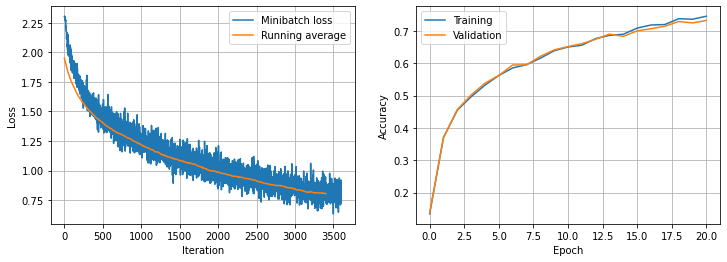

In [ ]:
epochs = 20
# BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_alexnet = nn.CrossEntropyLoss()
# END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
if training:
    log_dict = train_model(model, optimizer, loss_alexnet, epochs)
    print("Test set accuracy: ", check_accuracy(model, loader_test, device)[0])
    plot_accuracy_loss(log_dict, epochs)

Observe the number of parameters of the convolutional network. It is now around 2.5 times less than the original exapmple with a major increase in accuracy. Less parameters generally mean less computational effort as well.

## Exercise 2 B: Additional regularization

From the accuracy plot you should be able to observe how the difference between the validation and training accuracy is getting bigger with each epoch. This is because the model adapts to the training data but is not able to generalize to unseen data. This phenomenon is called overfitting. Of course there are techniques that can be used to help with overfitting.

To combat that, after each convolutional layer add [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). After each linear layer add [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html). Also add L2 regularization

Hint: L2 norm can be achieved by specifying `weight_decay > 0` to your optimizer. A good value to start should be `1e-5`

Think about your solution while experimenting. For example: Would I apply batch normalization before or after drop-out? What drop-out rate should I apply given the results I have seen so far? etc.

You should strive to achieve a difference between training and validation accuracy of less than 4% after 20 epochs.

In [34]:
def model_alexnet_regularized():
    return nn.Sequential(
# BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
        nn.Conv2d(3, 24, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(24),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        
        nn.Conv2d(24, 64, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        
        nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        
        nn.Flatten(),
        nn.Linear(96*4*4, 1024, device=device, dtype=dtype),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(p=0.55),
        
        nn.Linear(1024, 1024, device=device, dtype=dtype),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(p=0.55),
        
        nn.Linear(1024, 10, device=device, dtype=dtype)
# END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
)

model = model_alexnet_regularized()

trainable_parameters = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable parameters: {trainable_parameters}")

Trainable parameters: 2735610


One of the best ways to improve accuracy and reduce overfitting is data augmentation. Have a look at the [transforms](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) that PyTorch provides and think what would be suitable in this case.

In [35]:
# Add the transforms you beleive would help
train_transforms = T.Compose([T.Resize((70, 70)),
                                T.RandomCrop((64, 64)),
# BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                                T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
                                #T.RandomRotation(degrees=(0, 180)),                                 
# END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
                                T.ToTensor(),
                                T.Normalize((0.49139968, 0.48215827, 0.44653124), 
                                            (0.24703233, 0.24348505, 0.26158768))])

loader_train, loader_validation, loader_test = get_loaders(train_transforms=train_transforms)

Files already downloaded and verified


Define the loss and optimizer. Use Adam with learning rate of `0.001` and an appropriate loss.

Epoch:  1


  1%|          | 1/180 [00:44<2:12:23, 44.38s/it, loss=2.48]

Validation accuracy: 10.12  Deviation: 0.28


100%|██████████| 180/180 [01:32<00:00,  1.94it/s, loss=1.49]


Epoch:  2


  1%|          | 1/180 [00:44<2:14:14, 45.00s/it, loss=1.46]

Validation accuracy: 56.50  Deviation: -9.26


100%|██████████| 180/180 [01:33<00:00,  1.93it/s, loss=1.41]


Epoch:  3


  1%|          | 1/180 [00:44<2:11:33, 44.10s/it, loss=1.47]

Validation accuracy: 58.62  Deviation: -9.75


100%|██████████| 180/180 [01:31<00:00,  1.96it/s, loss=1.13]


Epoch:  4


  1%|          | 1/180 [00:44<2:14:05, 44.95s/it, loss=1.12]

Validation accuracy: 68.18  Deviation: -9.69


100%|██████████| 180/180 [01:32<00:00,  1.94it/s, loss=1.09]


Epoch:  5


  1%|          | 1/180 [00:44<2:11:28, 44.07s/it, loss=1.05]

Validation accuracy: 71.60  Deviation: -10.26


100%|██████████| 180/180 [01:30<00:00,  1.98it/s, loss=1.1]


Epoch:  6


  1%|          | 1/180 [00:44<2:12:03, 44.27s/it, loss=1.02]

Validation accuracy: 66.88  Deviation: -9.96


100%|██████████| 180/180 [01:30<00:00,  2.00it/s, loss=1.08]


Epoch:  7


  1%|          | 1/180 [00:42<2:07:22, 42.70s/it, loss=0.886]

Validation accuracy: 76.14  Deviation: -8.63


100%|██████████| 180/180 [01:28<00:00,  2.04it/s, loss=1]


Epoch:  8


  1%|          | 1/180 [00:43<2:09:52, 43.53s/it, loss=0.892]

Validation accuracy: 75.14  Deviation: -8.42


100%|██████████| 180/180 [01:31<00:00,  1.98it/s, loss=0.987]


Epoch:  9


  1%|          | 1/180 [00:44<2:12:05, 44.28s/it, loss=0.882]

Validation accuracy: 76.42  Deviation: -7.53


100%|██████████| 180/180 [01:30<00:00,  1.98it/s, loss=0.936]


Epoch:  10


  1%|          | 1/180 [00:43<2:10:32, 43.76s/it, loss=0.818]

Validation accuracy: 76.06  Deviation: -7.35


100%|██████████| 180/180 [01:30<00:00,  1.98it/s, loss=0.856]


Epoch:  11


  1%|          | 1/180 [00:43<2:10:16, 43.67s/it, loss=0.904]

Validation accuracy: 76.68  Deviation: -6.81


100%|██████████| 180/180 [01:30<00:00,  1.99it/s, loss=0.776]


Epoch:  12


  1%|          | 1/180 [00:43<2:10:51, 43.86s/it, loss=0.708]

Validation accuracy: 78.80  Deviation: -6.49


100%|██████████| 180/180 [01:31<00:00,  1.96it/s, loss=0.857]


Epoch:  13


  1%|          | 1/180 [00:43<2:11:08, 43.96s/it, loss=0.775]

Validation accuracy: 79.04  Deviation: -7.10


100%|██████████| 180/180 [01:31<00:00,  1.96it/s, loss=0.855]


Epoch:  14


  1%|          | 1/180 [00:44<2:12:45, 44.50s/it, loss=0.837]

Validation accuracy: 80.32  Deviation: -6.02


100%|██████████| 180/180 [01:31<00:00,  1.96it/s, loss=0.843]


Epoch:  15


  1%|          | 1/180 [00:43<2:08:47, 43.17s/it, loss=0.776]

Validation accuracy: 77.56  Deviation: -5.28


100%|██████████| 180/180 [01:30<00:00,  2.00it/s, loss=0.749]


Epoch:  16


  1%|          | 1/180 [00:43<2:10:37, 43.79s/it, loss=0.765]

Validation accuracy: 80.02  Deviation: -5.00


100%|██████████| 180/180 [01:29<00:00,  2.00it/s, loss=0.788]


Epoch:  17


  1%|          | 1/180 [00:43<2:10:47, 43.84s/it, loss=0.647]

Validation accuracy: 75.18  Deviation: -5.92


100%|██████████| 180/180 [01:31<00:00,  1.97it/s, loss=0.716]


Epoch:  18


  1%|          | 1/180 [00:43<2:09:54, 43.55s/it, loss=0.675]

Validation accuracy: 80.94  Deviation: -4.35


100%|██████████| 180/180 [01:30<00:00,  1.99it/s, loss=0.723]


Epoch:  19


  1%|          | 1/180 [00:43<2:11:15, 43.99s/it, loss=0.896]

Validation accuracy: 79.08  Deviation: -4.18


100%|██████████| 180/180 [01:30<00:00,  1.98it/s, loss=0.692]


Epoch:  20


  1%|          | 1/180 [00:43<2:09:19, 43.35s/it, loss=0.708]

Validation accuracy: 81.04  Deviation: -4.25


100%|██████████| 180/180 [01:29<00:00,  2.02it/s, loss=0.66]


Validation accuracy: 81.06  Deviation: -4.18
Test set accuracy:  0.8048


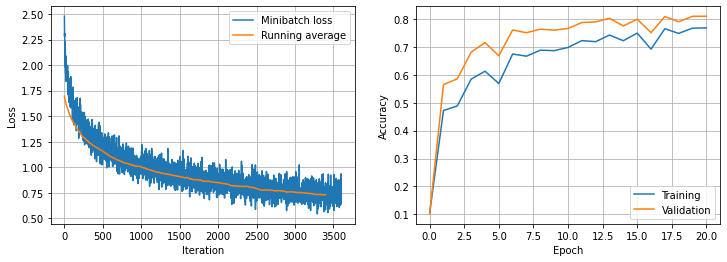

In [36]:
epochs = 20
# BEGIN your code here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
loss_alexnet_regularized = nn.CrossEntropyLoss()
# END <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
if training:
    log_dict = train_model(model, optimizer, loss_alexnet_regularized, epochs, device, 
                           loader_train, loader_validation)
    test_accuracy = check_accuracy(model, loader_test, device)[0]
    print("Test set accuracy: ", test_accuracy)
    plot_accuracy_loss(log_dict, epochs)
    
    log_dict.update({'test_accuracy': test_accuracy})
    
    with open('alexnet_regularized'+'.pkl', 'wb') as f:
        pickle.dump(log_dict, f)

If you decided to use colab to run this notebook you will need to download the checkpoints you saved. Please run the following block and add those files to your assignment repository.

In [37]:
if training:
    from google.colab import files
    files.download("alexnet_regularized.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>